# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience](https://towardsdatascience.com/genai-with-python-build-agents-from-scratch-complete-tutorial-4fc1e084e2ec)

### 0 - Setup

In [1]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1
#pip install duckduckgo-search --> 6.2.12
#pip install wikipedia --> 1.4.0

In [126]:
import ollama

llm = "llama3.1"
q = '''who died on September 9, 2024?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

{'model': 'llama3.1',
 'created_at': '2025-01-09T15:53:20.2072632Z',
 'message': {'role': 'assistant',
  'content': "I'm a large language model, I do not have the ability to predict the future or have access to real-time information about specific events. I can only provide general information and historical data.\n\nIf you're looking for information about someone who passed away on September 9th of any year, I'd be happy to try and help you with that! However, without more context or specific details, I won't be able to provide an answer to your question about who died on September 9, 2024.\n\nPlease note that my training data only goes up until 2021, so I wouldn't have any information about events happening after that date."},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 7081879400,
 'load_duration': 2892153000,
 'prompt_eval_count': 21,
 'prompt_eval_duration': 121000000,
 'eval_count': 132,
 'eval_duration': 3620000000}

### 1 - Tools

In [3]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser by passing the input `q`"""
    return DuckDuckGoSearchRun().run(q)

# test
print( tool_browser(q) )

D:\CourseIAGenAI\git\iagenai\fmi-2024-05-nlp-agents-intro\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


Famous deaths in September 2024. Learn about 53 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Alberto Fujimori. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. ... What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. Menu. Channels On This Day. Calendar; Search; September 2024. Events; ... Died in 2024 2024 Highlights. About September 9, 2024. Day of the Week: Monday 2024 Carroll Dawson, American basketball coach (Baylor University 1973-77) and executive (GM Houston Rockets 1996-2006), dies at 86; 2024 Cecília Gáspár, Hungarian soccer midfie

In [16]:
@tool("final_answer", parse_docstring=True)
def final_answer(text:str) -> str:
    """Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.
    
    Args:
        text: the text to be summarized as final answer
   
    Returns:
        bool: the resulting final answer text
    """
    return text

# test
print( final_answer("What is the first prime number?") )

What is the first prime number?


In [8]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

### 2 - Decision Making

In [9]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note in the memory.
Every time you find some information related to the user's question, you take note in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [10]:
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser by passing the input `q`
2. `final_answer`: Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.


In [11]:
# LLM deciding what tool to use
from pprint import pprint

llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

pprint(llm_res)

{'created_at': '2025-01-09T11:52:35.7170637Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 23,
 'eval_duration': 631000000,
 'load_duration': 2375501000,
 'message': {'content': '{"name":"final_answer", "parameters": {"text":"Hello! '
                        'How can I assist you today?"}}',
             'role': 'assistant'},
 'model': 'llama3.1',
 'prompt_eval_count': 315,
 'prompt_eval_duration': 465000000,
 'total_duration': 3918580500}


In [20]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name":"tool_browser", "parameters": {"q":"September 9 2024 notable deaths"}}'

In [19]:
import json

tool_input = json.loads(llm_res["message"]["content"])["parameters"]["q"]
tool_input

'September 9, 2024 death'

In [55]:
# LLM with context
context = tool_browser(tool_input)
print("tool output:\n", context)

llm_output = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context + 
               "\nIf there are more than one items in your answer format them as JSON list: [{answer1},{answer2},{answer3},...]\n"},
              {"role":"user", "content":q}
             ])

print("\nllm output:\n", llm_output["message"]["content"])

D:\CourseIAGenAI\git\iagenai\fmi-2024-05-nlp-agents-intro\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


tool output:
 Sep 9 Cecília Gáspár, Hungarian soccer midfielder and captain (28 caps; TSV Crailsheim, SGS Essen), dies at 39 James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), dies at 93 [1] [2] [3] Read on to remember the life and work of the celebrities who have died in 2024, including Beverly Hills, 90210 star Shannen Doherty, ... died on Monday Sept. 9 at 93. The actor, ... The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: ... [9] Norman Chui, 73, Hong Kong actor (Vengeful Beauty, Heaven Sword and Dragon Sabre, Hong Kong Godfather), esophageal cancer. Born Jan. 17, 1931 | Died Sept. 9, 2024 James Earl Jones debuted in the movie "Dr. Strangelove" in 1964, and went on to appear in "Coming To America" in 1988, and "Field of Dreams" in 1

### 3 - Agent Structure

##### Data Structure

In [56]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name":"tool_browser", "parameters": {"q":"September 9 2024 notable deaths"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 notable deaths'}, tool_output=None)

In [57]:
# test the tool output
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2024 deaths'}, 
         tool_output=str( tool_browser({'q':'September 9 2024 deaths'})) )

D:\CourseIAGenAI\git\iagenai\fmi-2024-05-nlp-agents-intro\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 53 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Alberto Fujimori. ... (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Famous deaths for the 9th of September. See which celebrities, historical figures, scientists and criminals died throughout history on September 9. Menu. Channels On This Day. Calendar; ... 2024 Carroll Dawson, American basketball coach (Baylor University 1973-77) and executive (GM Houston Rockets 1996-2006), dies at 86; What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. The following is a list of notable deaths in September 2024. Entries for each day are listed al

##### Memory System

In [80]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role":"assistant", "content":json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.'''+
                '''Only answer to the original query, and nothing else, but use the information I gave you. 
                If there are more than one items in your answer format them as JSON list: [{answer1},{answer2},{answer3},...{answerN}] when you use the `final_answer` tool.
                ''')}]
    return memory

# test
save_memory(lst_res=[agent_res], user_q=q)

[]

In [25]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Run the Agent

In [81]:
def run_agent(prompt:str, dic_tools:dict, user_q:str, chat_history:list[dict], lst_res:list[AgentRes]) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(dic_tools.keys()):
            memory[-1]["content"] = "You must now use the `final_answer` tool."

    ## prompt tools
    str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])
    prompt_tools = f"You can use the following tools:\n{str_tools}"
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    # pprint(messages) #<--print to see prompt + tools + chat_history
    
    ## output
    llm_res = ollama.chat(model=llm, messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(prompt=prompt, dic_tools=dic_tools, user_q=q, chat_history=chat_history, lst_res=[])
print("\nagent_res:", agent_res)


agent_res: tool_name='tool_browser' tool_input={'q': 'September 9, 2024 death'} tool_output=None


### 4 - Graph Workflow

##### State

In [82]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list 
    lst_res: list[AgentRes]
    output: dict

# test
state = State({"user_q":q, "chat_history":chat_history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9, 2024 death'}, tool_output=None)],
 'output': {}}

##### Nodes

In [83]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(prompt=prompt, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_browser","final_answer"]},
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a list of agent_res

# test
node_agent(state)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 death news'} tool_output=None


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 death news'}, tool_output=None)]}

In [116]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    res = state["lst_res"][-1]
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    print(f"{res.tool_name}(input={res.tool_input}, output={agent_res.tool_output})")
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---


D:\CourseIAGenAI\git\iagenai\fmi-2024-05-nlp-agents-intro\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


tool_browser(input={'q': 'September 9, 2024 death'}, output=What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. September 2024 1 Abel Alonso, 89, Spanish-Chilean ... Read on to remember the life and work of the celebrities who have died in 2024, including Beverly Hills, 90210 star Shannen Doherty, ... died on Monday Sept. 9 at 93. The actor, ... Born Jan. 17, 1931 | Died Sept. 9, 2024 James Earl Jones debuted in the movie "Dr. Strangelove" in 1964, and went on to appear in "Coming To America" in 1988, and "Field of Dreams" in 1989. Jones ... Sep 9 Cecília

{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9, 2024 death'}, tool_output='What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. September 2024 1 Abel Alonso, 89, Spanish-Chilean ... Read on to remember the life and work of the celebrities who have died in 2024, including Beverly Hills, 90210 star Shannen Doherty, ... died on Monday Sept. 9 at 93. The actor, ... Born Jan. 17, 1931 | Died Sept. 9, 2024 James Earl Jones debuted in the movie "Dr. Strangelove" in 1964, and went on to appear in "Coming To America" in 1988, and "Fie

##### Edges

In [74]:
def conditional_edges(state):
    print("--- conditional_edges ---")
    last_res = state["lst_res"][-1]
    next_node = last_res.tool_name if isinstance(state["lst_res"], list) else "final_answer"
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
conditional_edges(state)

--- conditional_edges ---
next_node: tool_browser


'tool_browser'

##### Graph

In [92]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent", path=conditional_edges)

## normal_edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

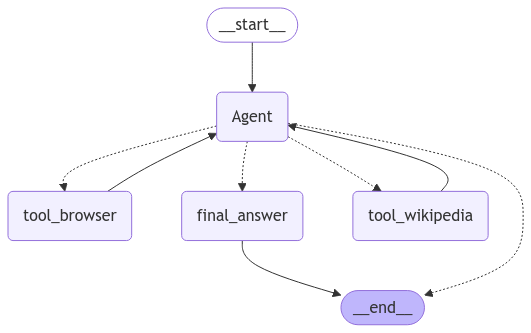

In [91]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

##### Run

In [90]:
## input initial state
initial_state = {'user_q':q,
                 'chat_history':chat_history, 
                 'lst_res':[],
                 'output':{} }

In [96]:
out = g.invoke(input=initial_state)
agent_out = out['output'].tool_output

print("----")
agent_out

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9, 2024 death'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'September 9, 2024 death'})


D:\CourseIAGenAI\git\iagenai\fmi-2024-05-nlp-agents-intro\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


--- node_agent ---
tool_name='final_answer' tool_input={'text': 'James Earl Jones, Abel Alonso and Cecília Gáspár died on September 9, 2024. James Earl Jones was an American actor who passed away at 93, Abel Alonso was a Spanish-Chilean and died at 89, and Cecília Gáspár was a Hungarian soccer midfielder who died at 39.'} tool_output=None
--- conditional_edges ---
next_node: final_answer
--- node_tool ---
final_answer(input={'text': 'James Earl Jones, Abel Alonso and Cecília Gáspár died on September 9, 2024. James Earl Jones was an American actor who passed away at 93, Abel Alonso was a Spanish-Chilean and died at 89, and Cecília Gáspár was a Hungarian soccer midfielder who died at 39.'})
----


'James Earl Jones, Abel Alonso and Cecília Gáspár died on September 9, 2024. James Earl Jones was an American actor who passed away at 93, Abel Alonso was a Spanish-Chilean and died at 89, and Cecília Gáspár was a Hungarian soccer midfielder who died at 39.'

In [97]:
steps = g.stream(input=initial_state) 
for n,step in enumerate(steps):
    print("--- step", n, "---")
    print(step)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- step 0 ---
{'Agent': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)]}}
--- node_tool ---
tool_browser(input={'q': 'September 9 2024 deaths'})


D:\CourseIAGenAI\git\iagenai\fmi-2024-05-nlp-agents-intro\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


--- step 1 ---
{'tool_browser': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 53 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Alberto Fujimori. ... (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. Famous deaths for the 9th of September. See which celebrities, historical figures, scientists and criminals died throughout history on September 9. Menu. Channels On This Day. Calendar; ... 2024 Carroll Dawson, American basketball coach (Baylor University 1973-77) and executive (GM Houston Rockets 1996-2006), dies at 86; The following is a list of notable deaths in Septe

### 5 - Multi-Agent & Human-in-the-Loop

##### Second Agent

In [98]:
agent_out

'James Earl Jones, Abel Alonso and Cecília Gáspár died on September 9, 2024. James Earl Jones was an American actor who passed away at 93, Abel Alonso was a Spanish-Chilean and died at 89, and Cecília Gáspár was a Hungarian soccer midfielder who died at 39.'

In [115]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool("tool_wikipedia")
def tool_wikipedia(q:str) -> str:
    """Search on Wikipedia by passing the input `q`.
       The input `q` must be short keywords, not a long text"""
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(q.split(',')[0])

# test
print( tool_wikipedia(agent_out) )
# print( tool_wikipedia("James Earl Jones actor") )

Page: James Earl Jones
Summary: James Earl Jones (January 17, 1931 – September 9, 2024) was an American actor. A pioneer for black actors in the entertainment industry, he is known for his extensive and acclaimed roles on stage and screen. Jones is one of the few performers to achieve the EGOT (Emmy, Grammy, Oscar, and Tony). He was inducted into the American Theater Hall of Fame in 1985, and was honored with the National Medal of Arts in 1992, the Kennedy Center Honor in 2002, the Screen Actors Guild Life Achievement Award in 2009, and the Academy Honorary Award in 2011.
Born in Arkabutla, Mississippi, Jones had a stutter from childhood. He said that poetry and acting helped him overcome the challenges of his disability. A pre-med major in college, he served as an officer in the U.S. Army during the Korean War before pursuing a career in acting. His deep voice was praised as a "stirring basso profondo that has lent gravel and gravitas" to his projects. Jones made his Broadway debut in

In [117]:
dic_tools = {"tool_browser":tool_browser,
             "final_answer":final_answer,
             "tool_wikipedia":tool_wikipedia}

In [118]:
prompt_2 = """
Your goal is to use the `tool_wikipedia` ONLY ONCE to enrich the information already available.
Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
First you must use the `tool_wikipedia`, then elaborate the information to answer the user's question with `final_answer` tool.
"""

In [119]:
def node_agent_2(state):
    print("--- node_agent 2 ---")
    agent_res = run_agent(prompt=prompt_2, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_wikipedia","final_answer"]},
                          user_q=state["output"].tool_output, #<--changed user_q to the last output
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return the list of agent_res

##### Human in the Loop

In [120]:
# Node
def human_node(state):
    pass

# Conditional Edges
def human_edges(state):
    print("--- human ---")
    user_feedback = input("Should I continue? [Yes/No] --> ")
    next_node = "Agent2" if user_feedback.lower()[0] == "y" else END
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
human_edges(state)

--- human ---
next_node: Agent2


'Agent2'

##### New Graph

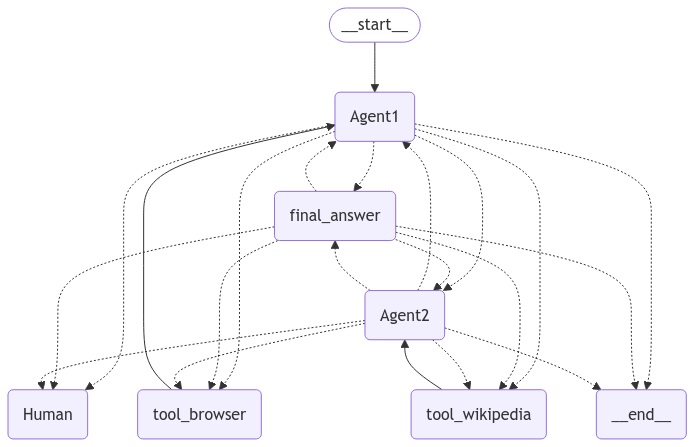

In [121]:
## start the graph
workflow = StateGraph(State)

########################## Agent 1 ##########################
## add Agent node
workflow.add_node(node="Agent1", action=node_agent) 
workflow.set_entry_point(key="Agent1") #<--user query

## add Tools nodes
workflow.add_node(node="tool_browser", action=node_tool)
workflow.add_node(node="final_answer", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_browser", end_key="Agent1")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent1", path=conditional_edges)

########################## Human ##########################
## add Human node
workflow.add_node(node="Human", action=human_node)

## conditional_edges from Human
workflow.add_conditional_edges(source="final_answer", path=human_edges)

########################## Agent 2 ##########################
## add Agent node
workflow.add_node(node="Agent2", action=node_agent_2) 

## add Tools nodes
workflow.add_node(node="tool_wikipedia", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_wikipedia", end_key="Agent2")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent2", path=conditional_edges)

########################## End ##########################
## end the graph
g2 = workflow.compile()

## plot
display(Image(
    g2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [123]:
initial_state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [],
 'output': {}}

In [124]:
out_2 = g2.invoke(input=initial_state)
agent_out_2 = out_2['output'].tool_output

print("----")
agent_out_2

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 death'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---


D:\CourseIAGenAI\git\iagenai\fmi-2024-05-nlp-agents-intro\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


tool_browser(input={'q': 'September 9 2024 death'}, output=Sep 9 Cecília Gáspár, Hungarian soccer midfielder and captain (28 caps; TSV Crailsheim, SGS Essen), dies at 39 James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), dies at 93 [1] [2] [3] What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: ... [9] Norman Chui, 73, Hong Kong actor (Vengeful Beauty, Heaven Sword and Dragon Sabre, Hong Kong Godfather), esophageal cancer. Born Jan. 17, 1931 | Died Sept. 9, 2024 James Earl Jones debuted in the movie "Dr. Strangelove" in 1964, and went on to appear in "Coming To America" in 1988, and "Field of

'James Earl Jones, an American actor best known for his iconic voice roles in Star Wars and The Lion King, passed away on September 9, 2024 at the age of 93. He was a legendary actor with a career spanning over six decades. According to Wikipedia, he was born on January 17, 1931, and died on September 9, 2024. He is known for his extensive and acclaimed roles on stage and screen, including his iconic voice role as Darth Vader in the Star Wars franchise.'